## Willingness to pay for Repairability for Mobile phones

### Import survey data

In [12]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder

In [13]:
data = pd.read_csv('data/survey_data_final.csv')
data = data.iloc[2:, :]

In [14]:
# Counts for invalid data before dropping
general_data = data.Finished.value_counts().rename_axis('subcategory').reset_index(name='counts')
general_data['category'] = "Finished survey"

phone_ownership_val = data["Phone ownership"].value_counts().rename_axis('subcategory').reset_index(name='counts')
phone_ownership_val['category'] = "Phone ownership"

general_data = pd.concat([general_data, phone_ownership_val], ignore_index=True)

In [15]:
def save_to_general_data(data, category, col_name, general_data):
    temp_df = data[category].value_counts().rename_axis('subcategory').reset_index(name='counts')
    temp_df['category'] = col_name
    general_data = pd.concat([general_data, temp_df], ignore_index=True)
    return general_data

### Data Cleaning and Exploration

In [16]:
## Drop invalid rows (not finished surveys, no data consents and contract still paying, missing value)
data = data.drop(data[data.Consent != "Yes"].index)
data = data.drop(data[data.Finished != "True"].index)
data = data.drop(data[data["Phone ownership"] == "Bought on contract - still paying"].index)
data = data.drop(data[data['phone cost_1'].isnull()].index)

In [17]:
# Counts for demographic variables and phone baseline information
categories = ["Gender", "Ethnicity", "Age", "Education", "Employment status", "Family size", "Income", "Phone ownership", "State of phone", "Brand of phone"]
for cat in categories:
    general_data = save_to_general_data(data, cat, cat, general_data)

In [18]:
## Select desired columns from responses and reformat column names
wanted_cols = ['Phone ownership',
               'Phone ownership_4_TEXT',
               'phone cost_1',
               'State of phone',
               'State of phone_5_TEXT',
               'Brand of phone',
               'Brand of phone_4_TEXT',
               'Attachments_1',
               'Attachments_2',
               'Attachments_3',
               'Attachments_4',
               'env - q_1',
               'env - why?',
               'env - why?_4_TEXT',
               'control - q_1',
               'control - why',
               'control - why_4_TEXT',
               'gov - q_1',
               'gov - why',
               'gov - why_4_TEXT',
               'Gender',
               'Gender_4_TEXT',
               'Age',
               'Ethnicity',
               'Education',
               'Education_8_TEXT',
               'Employment status',
               'Income',
               'Family size']
responses = data.filter(wanted_cols, axis=1)

# Renaming columns
responses = responses.rename(columns={'phone cost_1':'phone_cost',
                                      'Phone ownership_4_TEXT': 'phone_ownership_response', 
                                      'Gender_4_TEXT': 'gender_response',
                                      'Education_8_TEXT':'education_response', 
                                      'Brand of phone_4_TEXT': 'brand_phone_response',
                                      'State of phone':'state_phone',
                                      'Brand of phone': 'brand_phone',
                                      'State of phone_5_TEXT':'state_phone_response'})

responses = responses.rename(columns=str.lower)
responses.columns = responses.columns.str.replace(" ", "_")
            
print("Rows:", responses.shape[0], " Columns:", responses.shape[1])
print(responses['education'].value_counts())

Rows: 310  Columns: 29
Master's degree                                  125
Undergraduate degree                             115
Doctoral degree                                   29
Further education (16+, A-Levels, BTEC, etc.)     21
Secondary school (up to 16 years)                  8
Primary school                                     6
Other, please specify                              4
Prefer not to say                                  2
Name: education, dtype: int64


10.0


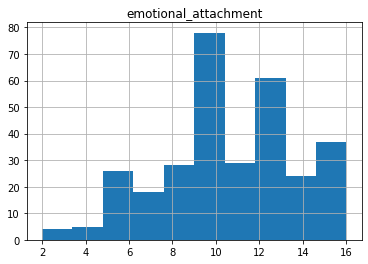

In [19]:
## Emotional Attachment - likert to numbers and sum 
likert_to_num = {"Strongly Disagree":0, "Somewhat Disagree":1, "Neither Agree nor Disagree": 2, "Somewhat Agree":3, "Strongly Agree":4}
attachment_cols = ['attachments_1', 'attachments_2', 'attachments_3', 'attachments_4']
for col in attachment_cols:
    responses[col] = responses[col].map(lambda x: likert_to_num[x])
    
responses['emotional_attachment'] = responses[attachment_cols].sum(axis=1)
print(responses['emotional_attachment'].median())
responses.hist(column='emotional_attachment')
# drop original attachment cols
responses = responses.drop(attachment_cols, axis=1)

# Saving emotional attachment data description
describe_emo = responses['emotional_attachment'].describe()

In [20]:
# Categorise emotional attachment at threshold 10
responses['emotional_attachment'] = np.where(responses['emotional_attachment'] > 13, 'high', 'low')
print("Emotional Attachment - high low split: \n", responses['emotional_attachment'].value_counts())

general_data = save_to_general_data(responses, 'emotional_attachment', 'Emotional Attachment', general_data)

Emotional Attachment - high low split: 
 low     249
high     61
Name: emotional_attachment, dtype: int64


In [21]:
## Create new column Treatment (env, gov, cont) to categorise different treatments, put all WTP into one column and all whys into one column
responses['treatment'] = ''
responses['treatment'] = np.where(responses['env_-_q_1'].notnull(), 'env', responses['treatment'])
responses['treatment'] = np.where(responses['gov_-_q_1'].notnull(), 'gov', responses['treatment'])
responses['treatment'] = np.where(responses['control_-_q_1'].notnull(), 'cont', responses['treatment'])

# Save data on counts
general_data = save_to_general_data(responses, 'treatment', 'Treatment', general_data)

# Combining all WTP to one column
q_cols = ['env_-_q_1', 'gov_-_q_1', 'control_-_q_1']
responses[q_cols] = responses[q_cols].apply(pd.to_numeric)
responses['WTP'] = responses[q_cols].sum(axis=1)
responses = responses.drop(q_cols, axis=1)

describe_WTP = responses['WTP'].describe()

# Combining survey written responses
why_cols = ['env_-_why?', 'env_-_why?_4_text', 'control_-_why', 'control_-_why_4_text', 'gov_-_why', 'gov_-_why_4_text']
responses['WTP_response'] = responses[why_cols].fillna('').sum(axis=1)
responses = responses.drop(why_cols, axis=1)

print("Rows:", responses.shape[0], " Columns:", responses.shape[1])

Rows: 310  Columns: 20


In [22]:
## Isolate protest zeros
protest_statements = ["It should be the producer's responsibility to pay",
                      "Other, please specifyrepairability is important to me but i can't afford a fair phone and the cameras are rubbish on them from seeing my friends",
                      "Other, please specifyPhones should be made repairable or more durable"]
responses['protest_flag'] = responses['WTP_response'].map(lambda res: True if (res in protest_statements) else False)

# Save data on counts
general_data = save_to_general_data(responses, 'protest_flag', 'Protest Flag', general_data)

print("Rows:", responses.shape[0], " Columns:", responses.shape[1])

Rows: 310  Columns: 21


In [23]:
## Willingness to pay as percentage of phone cost
describe_p_cost = responses['phone_cost'].describe()

responses['phone_cost'] = responses['phone_cost'].apply(pd.to_numeric)
responses['WTP_per'] = np.where(responses['phone_cost'] < 1, responses['phone_cost'], responses['WTP']/(responses['phone_cost']))
responses['WTP_per']= responses['WTP_per'].round(3)

describe_WTP_per = responses['WTP_per'].describe()

In [24]:
## Ethnicity categorisation
responses['ethnicity'] = responses['ethnicity'].map(lambda x: "White" if ("White" in x and "Mixed" not in x ) else ("Prefer not to say" if x == "Prefer not to say" else "BAME"))
general_data = save_to_general_data(responses, 'ethnicity', 'Ethnicity - categorised', general_data)

In [25]:
## Age categorisation
responses['age'] = responses['age'].map(lambda x: "Over 65" if (x == "65 - 74" or x == "75 - 84" or x == "85 or older"  ) else x)
general_data = save_to_general_data(responses, 'age', 'Age - categorised', general_data)

In [26]:
## Gender categorisation
responses['gender'] = responses['gender'].map(lambda x: "Prefer not to say" if x == "Prefer to self-describe" else x)
general_data = save_to_general_data(responses, 'gender', 'Gender - categorised', general_data)

In [27]:
## Combining describe data
describe_data = pd.DataFrame({'WTP': describe_WTP,'Phone cost': describe_p_cost,
                              'WTP per': describe_WTP_per, 'Emotional Attachment': describe_emo })

In [28]:
## Export to CSV
responses.to_csv('data/cleaned.csv', index=False)

export_cols = ['category', 'subcategory', 'counts'] 
general_data = general_data[export_cols]
general_data.to_csv('data/general_data.csv', index=False)

describe_data.to_csv('data/describe_data.csv', index=True)

### Model Preparation

In [29]:
## Choose variables wanted for modelling
model_vars = ['WTP_per', 'WTP', 'phone_cost', 'protest_flag', 'treatment', 'emotional_attachment', 'gender', 'age', 'ethnicity', 'education', 'employment_status', 'income',
             'family_size']
df = responses[model_vars].copy()
print("Rows:", df.shape[0], " Columns:", df.shape[1])

Rows: 310  Columns: 13


In [30]:
## age categorisation - binary
older = ["Over 65", "55 - 64", "45 - 54"]
df['age_bin'] = df['age'].map(lambda x: "Older" if (x in older ) else "Younger")
df['age_bin'].value_counts()

Younger    244
Older       66
Name: age_bin, dtype: int64

In [31]:
## income categorisation - binary
higher_income = ["£40,000 to £49,999", "£50,000 to £59,999", "£60,000 to £69,999",
                 "£70,000 to £79,999", "£80,000 to £89,999", "£90,000 to £99,999", "£100,000 to £149,999"]
df['income_bin'] = df['income'].map(lambda x: "Higher Income" if (x in higher_income ) else "Lower Income")
df['income_bin'].value_counts()

Lower Income     228
Higher Income     82
Name: income_bin, dtype: int64

In [32]:
## family size categorisation - binary
df['family_size_bin'] = df['family_size'].map(lambda x: "No dependents" if (x == "None" ) else "Have dependents")
df['family_size_bin'].value_counts()

No dependents      220
Have dependents     90
Name: family_size_bin, dtype: int64

In [33]:
## education categorisation - binary
higher_edu = ["Master's degree", "Doctoral degree"]
df['education_bin'] = df['education'].map(lambda x: "Higher Level Education" if (x in higher_edu ) else "Standard Education")
df['education_bin'].value_counts()

Standard Education        156
Higher Level Education    154
Name: education_bin, dtype: int64

In [34]:
## employment status categorisation - binary
employed = ["In full-time employment", "In part-time employment", "Self employed"]
df['employment_bin'] = df['employment_status'].map(lambda x: "Employed" if (x in employed) else "Not employed")
df['employment_bin'].value_counts()

Employed        189
Not employed    121
Name: employment_bin, dtype: int64

In [35]:
## Categorical expansion - one hot encoding
categorical_cols = ['treatment', 'emotional_attachment', 'gender', 'age', 'ethnicity',
                    'education', 'employment_status', 'income', 'family_size',
                    'education_bin', 'family_size_bin', 'income_bin', 'age_bin', 'employment_bin']

OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_res = pd.DataFrame(OH_encoder.fit_transform(df[categorical_cols]))
OH_res.columns = OH_encoder.get_feature_names_out(categorical_cols)
OH_res.index = df.index

model_data = pd.concat([df, OH_res], axis=1)
model_data = model_data.drop(categorical_cols, axis=1)

In [36]:
model_data.columns

Index(['WTP_per', 'WTP', 'phone_cost', 'protest_flag', 'treatment_cont',
       'treatment_env', 'treatment_gov', 'emotional_attachment_high',
       'emotional_attachment_low', 'gender_Female', 'gender_Male',
       'gender_Non-binary / third gender', 'gender_Prefer not to say',
       'age_18 - 24', 'age_25 - 34', 'age_35 - 44', 'age_45 - 54',
       'age_55 - 64', 'age_Over 65', 'age_Under 18', 'ethnicity_BAME',
       'ethnicity_Prefer not to say', 'ethnicity_White',
       'education_Doctoral degree',
       'education_Further education (16+, A-Levels, BTEC, etc.)',
       'education_Master's degree', 'education_Other, please specify',
       'education_Prefer not to say', 'education_Primary school',
       'education_Secondary school (up to 16 years)',
       'education_Undergraduate degree',
       'employment_status_In full-time education',
       'employment_status_In full-time employment',
       'employment_status_In part-time employment',
       'employment_status_Not in em

In [37]:
## Export to CSV
model_data.to_csv('data/model.csv', index=False)

### Modeling

In [38]:
baseline_vars = ['treatment_cont', 'emotional_attachment_low', 'gender_Female', 'age_18 - 24',
                 'ethnicity_White', "education_Master's degree", "employment_status_In full-time employment",
                "income_Less than £10,000", 'family_size_None', 
                 'education_bin_Standard Education', 'family_size_bin_No dependents', 'income_bin_Lower Income', 'age_bin_Younger', 'employment_bin_Employed']

drop_vars = ['gender_Non-binary / third gender', 'gender_Prefer not to say', 'income_Not sure', 
             'income_Prefer not to say', 'education_Prefer not to say', 'education_Other, please specify', 
             'ethnicity_Prefer not to say']

In [39]:
treatment_vars= []
emo_vars = []
eth_vars = []
gender_vars = []
age_vars = []
age_bin_vars = []
edu_vars = []
edu_bin_vars = []
emp_vars = []
emp_bin_vars = []
income_vars = []
income_bin_vars = []
fam_vars = []
fam_bin_vars = []

for col in model_data.columns:
    if col not in baseline_vars and col not in drop_vars:
        if 'treatment' in col:
            treatment_vars.append(col)
        elif 'emotional' in col:
            emo_vars.append(col)
        elif 'ethnicity' in col:
            eth_vars.append(col)
        elif 'gender' in col:
            gender_vars.append(col)
        elif 'age' in col:
            if 'age_bin' in col:
                age_bin_vars.append(col)
            else:
                age_vars.append(col)
        elif 'employment' in col:
            if 'employment_bin' in col:
                emp_bin_vars.append(col)
            else:
                emp_vars.append(col)
        elif'education' in col:
            if 'education_bin' in col:
                edu_bin_vars.append(col)
            elif 'education_' in col:
                edu_vars.append(col)
        elif 'income' in col:
            if 'income_bin' in col:
                income_bin_vars.append(col)
            else:
                income_vars.append(col)
        elif 'family' in col:
            if 'family_size_bin' in col:
                fam_bin_vars.append(col)
            else:
                fam_vars.append(col)

In [40]:
## Relationship columns
relationship_vars = []
bin_vars = eth_vars + gender_vars + age_bin_vars + edu_bin_vars + emp_bin_vars + income_bin_vars + fam_bin_vars + emo_vars
for treat in treatment_vars:
    for bi in bin_vars:
        col_name = treat+' x '+ bi
        relationship_vars.append(col_name)
        model_data[col_name] = model_data[treat].multiply(model_data[bi])

In [41]:
model_data = model_data.drop(model_data[model_data['protest_flag']== True].index)

model_data_cont = model_data.copy().drop(model_data[model_data['treatment_cont']== 0].index) 
model_data_env = model_data.copy().drop(model_data[model_data['treatment_env']== 0].index)
model_data_gov = model_data.copy().drop(model_data[model_data['treatment_gov']== 0].index)

In [42]:
relationship_vars

['treatment_env x ethnicity_BAME',
 'treatment_env x gender_Male',
 'treatment_env x age_bin_Older',
 'treatment_env x education_bin_Higher Level Education',
 'treatment_env x employment_bin_Not employed',
 'treatment_env x income_bin_Higher Income',
 'treatment_env x family_size_bin_Have dependents',
 'treatment_env x emotional_attachment_high',
 'treatment_gov x ethnicity_BAME',
 'treatment_gov x gender_Male',
 'treatment_gov x age_bin_Older',
 'treatment_gov x education_bin_Higher Level Education',
 'treatment_gov x employment_bin_Not employed',
 'treatment_gov x income_bin_Higher Income',
 'treatment_gov x family_size_bin_Have dependents',
 'treatment_gov x emotional_attachment_high']

## Final Modelling

In [43]:
def saving_experiments(exp_list, file_name, env_coef, gov_coef, save_flag=True):
    for ex in exp_list:
        if(save_flag):
            p = ex.params
            env_coef.append(p['treatment_env'])
            gov_coef.append(p['treatment_gov'])
        temp = pd.DataFrame(ex.summary().tables[1])
        temp.to_csv('results/'+file_name, mode='a', index=False, header=False)
    return (env_coef, gov_coef)

In [44]:
def mean_confidence_interval(data=[], confidence=0.95):
    mean = []
    ci = []
    for s in data:
        a = 1.0 * np.array(s)
        n = len(a)
        m, se = np.mean(a), st.sem(a)
        h = se * st.t.ppf((1 + confidence) / 2., n-1)
        mean.append(m)
        ci.append(h)
        
    return mean, ci

In [45]:
# Saving treatment coefficients
env_coef = []
gov_coef = []

### Results 1: WTP and WTP% data 

<AxesSubplot:ylabel='Frequency'>

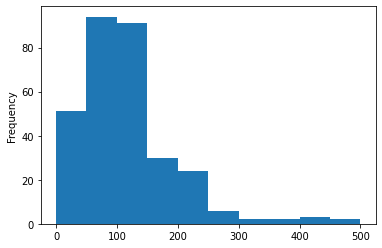

In [46]:
model_data['WTP'].plot(kind='hist')

In [47]:
data_wtp = [model_data['WTP'], model_data_cont['WTP'], model_data_env['WTP'], model_data_gov['WTP']]
mean_WTP, ci_WTP = mean_confidence_interval(data_wtp)

In [48]:
data_wtp_per = [model_data['WTP_per'], model_data_cont['WTP_per'], model_data_env['WTP_per'], model_data_gov['WTP_per']]
mean_WTP_per, ci_WTP_per = mean_confidence_interval(data_wtp_per)

In [49]:
res1_data = pd.DataFrame({'Mean WTP': mean_WTP,'Confidence Interval WTP': ci_WTP,
                              'Mean WTP per': mean_WTP_per, 'Confidence Interval WTP oer': ci_WTP_per })
res1_data.to_csv('res1.csv', index=False)

### Experiment 2: Seperate regression with core variables and socioeconomic variables

In [50]:
# Model 6: All - X (income + education + employment + fam)
mod6_vars = treatment_vars + income_vars + edu_vars + emp_vars + fam_vars
mod6_X = model_data[mod6_vars]
mod6_y = model_data['WTP_per']

mod6 = sm.OLS(mod6_y, mod6_X)
res6 = mod6.fit()

In [51]:
exp_2 = [res6]
env_coef, gov_coef = saving_experiments(exp_2, 'experiment_2.csv', env_coef, gov_coef)

NameError: name 'res1' is not defined

### Experiment 3: Emotional attachment regression with both treatments

In [53]:
# Model 7: All - X (treatments + emotional)
mod7_vars = treatment_vars + emo_vars + ['phone_cost']
mod7_X = model_data[mod7_vars]
mod7_y = model_data['WTP']

mod7 = sm.OLS(mod7_y, mod7_X)
res7 = mod7.fit()

In [41]:
exp_3 = [res7]
env_coef, gov_coef = saving_experiments(exp_3, 'res_3.csv', env_coef, gov_coef, False)

### Experiment 4: Relationship between env treatment and each demographic variable

In [42]:
# Model 8: All - X (treatments + gender + treatment x gender)
mod8_vars = treatment_vars  + bin_vars + ['treatment_env x gender_Male', 'treatment_gov x gender_Male', 'phone_cost']
mod8_X = model_data[mod8_vars]
mod8_y = model_data['WTP']

mod8 = sm.OLS(mod8_y, mod8_X)
res8 = mod8.fit()

In [43]:
# Model 9: All - X (treatments + ethnicity + treatment x ethnicity)
mod9_vars = treatment_vars + bin_vars + ['treatment_env x ethnicity_BAME', 'treatment_gov x ethnicity_BAME', 'phone_cost']
mod9_X = model_data[mod9_vars]
mod9_y = model_data['WTP']

mod9 = sm.OLS(mod9_y, mod9_X)
res9 = mod9.fit()

In [44]:
# Model 10: All - X (treatments + age + treatment x age)
mod10_vars = treatment_vars + bin_vars + ['treatment_env x age_bin_Older', 'treatment_gov x age_bin_Older', 'phone_cost']
mod10_X = model_data[mod10_vars]
mod10_y = model_data['WTP']

mod10 = sm.OLS(mod10_y, mod10_X)
res10 = mod10.fit()

In [45]:
# Model 11 :All - X (treatments + income + treatment x income)
mod11_vars = treatment_vars + bin_vars + ['treatment_env x income_bin_Higher Income', 'treatment_gov x income_bin_Higher Income', 'phone_cost']
mod11_X = model_data[mod11_vars]
mod11_y = model_data['WTP']

mod11 = sm.OLS(mod11_y, mod11_X)
res11 = mod11.fit()

In [46]:
# Model 12 :All - X (treatments + employment + treatment x employment)
mod12_vars = treatment_vars + bin_vars + ['treatment_env x employment_bin_Not employed', 'treatment_gov x employment_bin_Not employed', 'phone_cost']
mod12_X = model_data[mod12_vars]
mod12_y = model_data['WTP']

mod12 = sm.OLS(mod12_y, mod12_X)
res12 = mod12.fit()

In [47]:
# Model 13 :All - X (treatments + family size + treatment x family size)
mod13_vars = treatment_vars + bin_vars + ['treatment_env x family_size_bin_Have dependents', 'treatment_gov x family_size_bin_Have dependents', 'phone_cost']
mod13_X = model_data[mod13_vars]
mod13_y = model_data['WTP']

mod13 = sm.OLS(mod13_y, mod13_X)
res13 = mod13.fit()

In [48]:
# Model 14 :All - X (treatments + edu + treatment x edu)
mod14_vars = treatment_vars + bin_vars + ['treatment_env x education_bin_Higher Level Education', 'treatment_gov x education_bin_Higher Level Education', 'phone_cost']
mod14_X = model_data[mod14_vars]
mod14_y = model_data['WTP']

mod14 = sm.OLS(mod14_y, mod14_X)
res14 = mod14.fit()

In [49]:
# Model 15 :All - X (treatments + emo + treatment x emo)
mod15_vars = treatment_vars + bin_vars + emo_vars + ['treatment_env x emotional_attachment_high', 'treatment_gov x emotional_attachment_high', 'phone_cost']
mod15_X = model_data[mod15_vars]
mod15_y = model_data['WTP']

mod15 = sm.OLS(mod15_y, mod15_X)
res15 = mod15.fit()

In [53]:
# Model 16 :All - X (treatments + emo + treatment x emo)
mod16_vars = treatment_vars + bin_vars +  relationship_vars + ['phone_cost']
mod16_X = model_data[mod16_vars]
mod16_y = model_data['WTP']

mod16 = sm.OLS(mod16_y, mod16_X)
res16 = mod16.fit()

In [50]:
#TODO (maybe no saving coefficients)
exp_4 = [res8, res9, res10, res11, res12, res13, res14, res15]
env_coef, gov_coef = saving_experiments(exp_4, 'res_4.csv', env_coef, gov_coef, False)

In [54]:
#TODO (maybe no saving coefficients)
exp_4a = [res16]
env_coef, gov_coef = saving_experiments(exp_4a, 'res_7.csv', env_coef, gov_coef, False)

### Experiment 5: T-test for treatment coefficients

In [120]:
t_test = sm.stats.ttest_ind(gov_coef, env_coef)
print("t val:", t_test[0], "p val:", t_test[1], "degrees of freedom:", t_test[2])

t val: 6.967418164824702 p val: 6.579031130223904e-06 degrees of freedom: 14.0


In [106]:
env_coef

[27.231989954501454,
 27.179814447469436,
 24.135359680809078,
 20.960637780235086,
 20.617532883951778,
 27.231989954501454,
 22.590380438882605,
 36.39483874918492]

### Experiment 6: Increasing socio economic variables until we have full model with all variables

In [110]:
# Model 22: All - X (treatment_vars, core)
mod22_vars = treatment_vars + age_vars + gender_vars + eth_vars + ['phone_cost']
mod22_X = model_data[mod22_vars]
mod22_y = model_data['WTP']

mod22 = sm.OLS(mod22_y, mod22_X)
res22 = mod22.fit()

In [111]:
# Model 23: All - X (treatment_vars, core + income)
mod23_vars = treatment_vars + age_vars + gender_vars + eth_vars + income_vars + ['phone_cost']
mod23_X = model_data[mod23_vars]
mod23_y = model_data['WTP']

mod23 = sm.OLS(mod23_y, mod23_X)
res23 = mod23.fit()

In [112]:
# Model 24: All - X (treatment_vars, core + income + education)
mod24_vars = treatment_vars + age_vars + gender_vars + eth_vars + income_vars + edu_vars + ['phone_cost']
mod24_X = model_data[mod24_vars]
mod24_y = model_data['WTP']

mod24 = sm.OLS(mod24_y, mod24_X)
res24 = mod24.fit()

In [113]:
# Model 25: All - X (treatment_vars, core + income + education + employment)
mod25_vars = treatment_vars + age_vars + gender_vars + eth_vars + income_vars + edu_vars + emp_vars + ['phone_cost']
mod25_X = model_data[mod25_vars]
mod25_y = model_data['WTP']

mod25 = sm.OLS(mod25_y, mod25_X)
res25 = mod25.fit()

In [51]:
# Model 26: All - X (treatment_vars, core + income + education + employment + fam [ALL])
mod26_vars = treatment_vars + bin_vars + ['phone_cost']
mod26_X = model_data[mod26_vars]
mod26_y = model_data['WTP']

mod26 = sm.OLS(mod26_y, mod26_X)
res26 = mod26.fit()

In [52]:
exp_6 = [res26]
env_coef, gov_coef = saving_experiments(exp_6, 'res_6.csv', env_coef, gov_coef)

In [35]:
# Model 27: All - X (treatment_vars, core + income + education + employment + fam [ALL])
mod27_vars = treatment_vars + eth_vars + gender_vars + age_vars + edu_vars + emp_vars + income_vars + fam_vars + emo_vars + ['phone_cost']
mod27_X = model_data[mod27_vars]
mod27_y = model_data['WTP']

mod27 = sm.OLS(mod27_y, mod27_X)
res27 = mod27.fit()

In [36]:
exp_7 = [res27]
env_coef, gov_coef = saving_experiments(exp_7, 'res_7.csv', env_coef, gov_coef)

In [78]:
rvs1 = st.norm.rvs(loc=1, scale=1, size=5)
print(rvs1)

[ 1.76324241  1.491881    0.01093343  0.11963783 -0.75453028]


In [73]:
rvs1 = st.norm.rvs(loc=61, scale=21, size=len(model_data['WTP']))
st.ttest_ind(model_data['WTP'], rvs1)

Ttest_indResult(statistic=9.513563615725063, pvalue=4.241324928015273e-20)

In [74]:
rvs2 = st.norm.rvs(loc=61, scale=21, size=len(model_data_cont['WTP']))
st.ttest_ind(model_data_cont['WTP'], rvs2)

Ttest_indResult(statistic=5.263880923003739, pvalue=3.396049537587895e-07)

In [68]:
rvs3 = st.norm.rvs(loc=61, scale=21, size=len(model_data_env['WTP']))
st.ttest_ind(rvs3, model_data_env['WTP'])

Ttest_indResult(statistic=-5.494028537857255, pvalue=1.2370248765754503e-07)

In [69]:
rvs4 = st.norm.rvs(loc=61, scale=21, size=len(model_data_gov['WTP']))
st.ttest_ind(rvs4, model_data_gov['WTP'])

Ttest_indResult(statistic=-6.526435966914111, pvalue=5.626508871631182e-10)

In [72]:
model_data_cont["WTP"].mean()

60.538494482280846